In [ ]:
#Control Loop

#1. Determine the current location of the parafoil system relative to the target location. (Using altimeter and GPS)

#2. Determine the altitude required to complete all admissible Dubins paths.

#3. Determine the normalized altitude margin η from the optimal (minimum-time) Dubins path.

#4. Determine the type of reference trajectory to calculate based on the following:
    # - If η > 5 compute an energy management trajectory (discussed below).
    # - If 1 < η ≤ 5 compute a minimum control-energy trajectory.
    # - If 0 ≤ η ≤ 1 compute a modified Dubins trajectory
    # - If η < 0 track directly toward the target to minimize the miss distance.
#Calculate and store x(t), y(t), phi(t)

#Twitch motors pased on these parameters. 

In [2]:
from __future__ import division
import numpy as np
from math import tan, sin, cos, atan2, fmod, acos, asin, pow, sqrt, fabs,atan

pi = np.pi

# create the results dictionary
DubinsAirplaneSolution = {}
DubinsAirplaneSolution['case'] = 0
DubinsAirplaneSolution['p_s'] = np.zeros((3,1))
DubinsAirplaneSolution['angl_s'] = 0
DubinsAirplaneSolution['p_e'] = np.zeros((3,1))
DubinsAirplaneSolution['R'] = 0
DubinsAirplaneSolution['gamma'] = 0
DubinsAirplaneSolution['L'] = 0
DubinsAirplaneSolution['c_s'] = np.zeros((3,1))
DubinsAirplaneSolution['psi_s'] = 0
DubinsAirplaneSolution['lamda_s'] = 0
DubinsAirplaneSolution['lamda_si'] = 0
DubinsAirplaneSolution['k_s'] = 0
DubinsAirplaneSolution['c_ei'] = np.zeros((3,1))
DubinsAirplaneSolution['c_si'] = np.zeros((3,1))
DubinsAirplaneSolution['psi_ei'] = 0
DubinsAirplaneSolution['lamda_ei'] = 0
DubinsAirplaneSolution['psi_si'] = 0
DubinsAirplaneSolution['k_ei'] = 0
DubinsAirplaneSolution['c_e'] = 0
DubinsAirplaneSolution['k_si'] = 0
DubinsAirplaneSolution['psi_e'] = 0
DubinsAirplaneSolution['lamda_e'] = 0
DubinsAirplaneSolution['k_e'] = 0
DubinsAirplaneSolution['w_s'] = np.zeros((3,1))
DubinsAirplaneSolution['q_s'] = np.zeros((3,1))
DubinsAirplaneSolution['w_si'] = np.zeros((3,1))
DubinsAirplaneSolution['q_si'] = np.zeros((3,1))
DubinsAirplaneSolution['w_l'] = np.zeros((3,1))
DubinsAirplaneSolution['q_l'] = np.zeros((3,1))
DubinsAirplaneSolution['w_ei'] = np.zeros((3,1))
DubinsAirplaneSolution['q_ei'] = np.zeros((3,1))
DubinsAirplaneSolution['w_e'] = np.zeros((3,1))
DubinsAirplaneSolution['q_e'] = np.zeros((3,1))

def roty(theta=None):
    # Rotation around y
    R = np.array([  [cos(theta),    0,      sin(theta)],
                    [0,             1,      0],
                    [-sin(theta),   0,      cos(theta)] ])
    return R
    

def rotz(theta=None):
    # Rotation around z
    R = np.array([  [cos(theta),    -sin(theta),    0],
                    [sin(theta),    cos(theta),     0],
                    [0,             0,              1]  ])
    return R


def computeDubinsRSR(R=None, crs=None, cre=None, anglstart=None,anglend=None):
    # Compute Dubins RSR
    theta = atan2( cre[1]-crs[1], cre[0]-crs[0] )
    L = np.linalg.norm( crs[0:2]-cre[0:2],ord=2 ) + R* fmod( 2*pi+fmod(theta-pi/2,2*pi )-fmod( anglstart-pi/2,2*pi),2*pi ) + R*fmod( 2*pi+fmod(anglend-pi/2,2*pi )-fmod( theta-pi/2,2*pi),2*pi )
    return L


def computeDubinsLSL(R=None, cls=None, cle=None, anglstart=None, anglend=None):
    # Compute Dubins LSL
    theta = atan2( cle[1]-cls[1], cle[0]-cls[0] )
    L = np.linalg.norm(cls[0:2]-cle[0:2]) + R*fmod( 2*pi-fmod(theta+pi/2,2*pi)+fmod(anglstart+pi/2,2*pi),2*pi ) + R*fmod( 2*pi-fmod(anglend+pi/2,2*pi)+fmod(theta+pi/2,2*pi),2*pi )
    return L

def computeDubinsLSR(R=None, cls=None, cre=None, anglstart=None, anglend=None):
    # Compute Dubins LSR
    ell = np.linalg.norm( cre[0:2]-cls[0:2],ord=2 )
    theta = atan2( cre[1]-cls[1],cre[0]-cls[0] )
    acos_value = 2 * R / ell
    if fabs( acos_value ) > 1:
        flag_zero = 1
    else:
        flag_zero = 0
    
    acos_value = max( acos_value,-1 )
    acos_value = min( acos_value,1 )
    if ell == 0:
        theta2 = 0
    else:
        theta2 = acos( acos_value )
    
    if flag_zero == 1:
        theta2 = 0
    
    if theta2 == 0:
        L = pow(10.0,8)
    else:
        L = sqrt( pow(ell,2) - 4*pow(R,2) ) + R*fmod( 2*pi-fmod(theta+theta2,2*pi ) + fmod( anglstart+pi/2,2*pi),2*pi ) + R*fmod( 2*pi-fmod(theta+theta2-pi,2*pi)+fmod(anglend-pi/2,2*pi),2*pi )
    return L

def computeDubinsRSL(R=None, crs=None, cle=None, anglstart=None, anglend=None):
    # Compute Dubins RSL
    ell = np.linalg.norm( cle[0:2]-crs[0:2],ord=2 )
    theta = atan2( cle[1]-crs[1],cle[0]-crs[0] )
    asin_value = 2 * R / ell
    if fabs( asin_value ) > 1:
        flag_zero = 1
    else:
        flag_zero = 0
    asin_value = max( asin_value, -1 )
    asin_value = min( asin_value, 1 )
    if ell == 0:
        theta2 = 0
    else:
        theta2 = theta - pi/2 + asin( asin_value )
    
    if theta2 == 0:
        L = pow( 10.0, 8 )
    else:
        L = sqrt( fabs(pow(ell,2)-4 * pow(R,2)) ) + R * fmod( 2 * pi + fmod( theta2, 2 * pi )-fmod( anglstart-pi/2, 2 * pi ), 2 * pi ) + R * fmod( 2 * pi + fmod( theta2 + pi, 2 * pi )-fmod( anglend + pi / 2, 2 * pi ), 2 * pi )
    return L

def computeOptimalRadius(zs=None, anglstart=None, ze=None, anglend=None, R_min=None, gamma_max=None, idx=None, k=None, hdist=None):
    # Compute Optimal Radius
    R1 = R_min
    R2 = 2 * R_min
    R = ( R1 + R2 ) / 2
    
    if idx == 1:
        error = 1
        while fabs( error ) > 0.1:
            crs = zs + R * np.dot( rotz( pi / 2 ),np.array( [cos(anglstart), sin(anglstart), 0] ).T )
            cre = ze + R * np.dot( rotz( pi / 2 ), np.array( [cos(anglend), sin(anglend), 0] ).T )
            L = computeDubinsRSR(R, crs, cre, anglstart, anglend)
            error = ( L + 2 * pi * k * R ) - fabs( hdist ) / tan( gamma_max )
            if error > 0:
                R2 = R
            else:
                R1 = R
            R= ( R1 + R2 ) / 2
    elif idx == 2:
        error = 1
        while fabs( error ) > 0.1:
            crs = zs + R * np.dot( rotz( pi / 2 ),np.array( [cos(anglstart), sin(anglstart), 0] ).T )
            cle = ze + R * np.dot( rotz( -pi/2 ),np.array( [cos(anglend), sin(anglend), 0] ).T )
            L = computeDubinsRSL( R, crs, cle, anglstart, anglend )
            error = ( L + 2 * pi * k * R ) * tan( gamma_max ) - fabs( hdist )
            if error > 0:
                R2 = R
            else:
                R1 = R
            R = ( R1 + R2 ) / 2
    elif idx == 3:
        error = 1
        while fabs( error ) > 0.1:
            cls = zs + R * np.dot( rotz( -pi / 2 ), np.array( [cos(anglstart), sin(anglstart), 0] ).T )
            cre = ze + R * np.dot( rotz( pi / 2 ), np.array( [cos(anglend), sin(anglend), 0] ).T )
            L = computeDubinsLSR( R, cls, cre, anglstart, anglend )
            error = ( L + 2 * pi * k * R ) * tan( gamma_max ) - fabs( hdist )
            if error > 0:
                R2 = R
            else:
                R1 = R
            R = ( R1 + R2 ) / 2
    elif idx == 4: 
        error = 1
        while fabs( error ) > 0.1:
            cls = zs + R * np.dot( rotz( -pi / 2 ), np.array( [cos(anglstart), sin(anglstart), 0] ).T )
            cle = ze + R * np.dot( rotz( -pi / 2 ), np.array( [cos(anglend), sin(anglend), 0] ).T )
            L = computeDubinsLSL( R, cls, cle, anglstart, anglend )
            error = ( L + 2 * pi * k * R ) * tan( gamma_max ) - fabs( hdist )
            if error > 0:
                R2 = R
            else:
                R1 = R
            R = ( R1 + R2 ) / 2
    return R


    

def MinTurnRadius_DubinsAirplane(V=None,phi_max=None):
    # Compute Minimum Turning Radius
    g = 9.8065
    Rmin = pow( V,2 ) / (g * tan( phi_max ) )
    return Rmin

def addSpiralBeginning(zs=None, anglstart=None, ze=None, anglend=None, R_min=None, gamma_max=None, idx=None, hdist=None):
    cli = np.zeros((3,1))
    cri = np.zeros((3,1))
    zi = np.zeros((3,1))
    anglinter = 0
    L = 0 
    ci = np.zeros((3,1))
    psii = 0
    psi1 = 0
    psi2 = 2 * pi
    psi = ( psi1 + psi2 ) / 2
    
    if idx == 1: # RLSR
        crs = zs + R_min * np.dot( rotz( pi/2 ), np.array( [cos(anglstart), sin(anglstart), 0] ).T )
        cre = ze + R_min * np.dot( rotz( pi/2 ), np.array( [cos(anglend), sin(anglend), 0] ).T )
        L = computeDubinsRSR( R_min, crs, cre, anglstart, anglend )
        error = L - fabs( hdist / tan( gamma_max ) )
        while fabs( error ) > 0.001:
            zi = crs + np.dot( rotz( psi ),( zs-crs ) )
            anglinter = anglstart + psi
            cli = zi + R_min * np.dot( rotz( -pi/2 ), np.array( [cos(anglinter), sin(anglinter), 0] ).T )
            L = computeDubinsLSR( R_min, cli, cre, anglinter, anglend )
            error = ( L + fabs( psi ) * R_min ) - fabs( hdist / tan( gamma_max ) )
            
            if error > 0:
                psi2 = (179*psi2+psi)/180
            else:
                psi1 = (179*psi1+psi)/180
            
            psi = ( psi1 + psi2 ) / 2
        
        zi = crs + np.dot( rotz( psi ), ( zs-crs ) )
        anglinter = anglstart + psi
        L = L + fabs( psi ) * R_min
        ci = cli
        psii = psi
    
    elif idx == 2: # RLSL
        crs = zs + R_min * np.dot( rotz( pi / 2 ), np.array( [cos(anglstart), sin(anglstart), 0] ).T )
        cle = ze + R_min * np.dot( rotz( -pi / 2 ), np.array( [cos(anglend), sin(anglend), 0] ).T )
        L = computeDubinsRSL( R_min, crs, cle, anglstart, anglend )
        error = L - fabs( hdist / tan( gamma_max ) )
        while fabs( error ) > 0.001:
            zi = crs + np.dot( rotz( psi ), ( zs-crs ) )
            anglinter = anglstart + psi
            cli = zi + R_min * np.dot( rotz( -pi / 2 ), np.array( [cos(anglinter), sin(anglinter), 0] ).T )
            L = computeDubinsLSL( R_min, cli, cle, anglinter, anglend )
            error = ( L + fabs( psi ) * R_min ) - fabs( hdist / tan( gamma_max ) )
            
            if error > 0:
                psi2 = (179*psi2+psi)/180
            else:
                psi1 = (179*psi1+psi)/180
            
            psi = ( psi1 + psi2 ) / 2
        
        zi   = crs + np.dot( rotz( psi ), ( zs-crs ) )
        anglinter = anglstart + psi
        anglend = zi + anglinter
        L = L + fabs( psi ) * R_min
        ci = cli
        psii = psi
    
    elif idx == 3: # LRSR
        cls = zs + R_min * np.dot( rotz( -pi/2 ), np.array( [cos(anglstart), sin(anglstart), 0] ).T )
        cre = ze + R_min * np.dot( rotz( pi/2 ), np.array( [cos(anglend), sin(anglend), 0] ).T )
        L = computeDubinsLSR( R_min, cls, cre, anglstart, anglend )
        error = L - fabs( hdist / tan( gamma_max ) )
        
        while fabs( error ) > 0.001:
            zi = cls + np.dot( rotz( -psi ), ( zs-cls ) )
            anglinter = anglstart - psi
            cri = zi + R_min * np.dot( rotz( pi / 2 ), np.array( [cos(anglinter), sin(anglinter), 0] ).T )
            L = computeDubinsRSR( R_min, cri, cre, anglinter, anglend )
            error = ( L + fabs( psi ) * R_min ) - fabs( hdist / tan( gamma_max ) )
            
            if error > 0:
                psi2 = (179*psi2+psi)/180
            else:
                psi1 = (179*psi1+psi)/180
            
            psi = ( psi1 + psi2 ) / 2
        
        zi   = cls + np.dot( rotz( -psi ), ( zs-cls ) )
        anglinter = anglstart - psi
        L = L + fabs( psi ) * R_min
        ci = cri
        psii = psi
    
    elif idx == 4: # LRSL
        cls = zs + R_min * np.dot( rotz( -pi/2 ), np.array( [cos(anglstart), sin(anglstart), 0] ).T )
        cle = ze + R_min * np.dot( rotz( -pi/2 ), np.array( [cos(anglend), sin(anglend), 0] ).T )
        # origin is "cre = ze + R_min * np.dot( rotz( -pi/2 ), np.array( [cos(anglend), sin(anglend), 0] ).T )"
        L = computeDubinsLSL( R_min, cls, cle, anglstart, anglend )
        error = L - fabs( hdist / tan( gamma_max ) )
        
        while fabs( error ) > 0.001:
            zi = cls + np.dot( rotz( -psi ), ( zs-cls ) )
            anglinter = anglstart - psi
            cri = zi + R_min * np.dot( rotz( pi / 2 ), np.array( [cos(anglinter), sin(anglinter), 0 ] ).T )
            # above is modified by licz 2015-10-12, fix written mistake np.array -> np.dot
            # origin is "cri = zi + R_min * np.array( rotz( pi / 2 ), np.array( [cos(anglinter), sin(anglinter), 0 ] ).T )"
            L = computeDubinsRSL( R_min, cri, cle, anglinter, anglend )
            error = ( L + fabs( psi ) * R_min ) - fabs( hdist / tan( gamma_max) )
            
            if error > 0:
                psi2 = (179*psi2+psi)/180
            else:
                psi1 = (179*psi1+psi)/180
            
            psi = ( psi1 + psi2 ) / 2
        
        zi   = cls + np.dot( rotz( -psi ), ( zs-cls ) )
        anglinter = anglstart - psi
        L = L + fabs( psi ) * R_min
        ci = cri
        psii = psi
    
    return zi, anglinter, L, ci, psii


def addSpiralEnd(zs=None, anglstart=None, ze=None, anglend=None, R_min=None, gamma_max=None, idx=None, hdist=None):
    # Add Spiral at the end of the Dubins Airplane path
    cli = np.zeros((3,1))
    cri = np.zeros((3,1))
    zi = np.zeros((3,1))
    anglinter = 0
    L = 0
    ci = np.zeros((3,1))
    psii = 0
    psi1 = 0
    psi2 = 2 * pi
    psi = ( psi1 + psi2 ) / 2
    
    if idx == 1: # RSLR
        crs = zs + R_min * np.dot( rotz( pi / 2 ), np.array( [cos(anglstart), sin(anglstart), 0] ).T )
        cre = ze + R_min * np.dot( rotz( pi/2 ), np.array( [cos(anglend), sin(anglend), 0] ).T )
        L = computeDubinsRSR( R_min, crs, cre, anglstart, anglend )
        error = L - fabs( hdist / tan( gamma_max ) )
        
        while fabs( error ) > 0.001:
            zi = cre + np.dot( rotz( -psi ), ( ze-cre ) )
            anglinter = anglend - psi
            cli = zi + R_min * np.dot( rotz( -pi / 2 ), np.array( [cos(anglinter), sin(anglinter), 0] ).T )
            L = computeDubinsRSL( R_min, crs, cli, anglstart, anglinter )
            error = ( L + fabs( psi ) * R_min ) - fabs( hdist / tan( gamma_max ) )
            
            if error > 0:
                psi2 = (179*psi2+psi)/180
            else:
                psi1 = (179*psi1+psi)/180
            
            psi = ( psi1 + psi2 ) / 2
        
        zi   = cre + np.dot( rotz( -psi ), ( ze-cre ) )
        anglinter = anglend - psi
        L = L + abs( psi ) * R_min
        ci = cli
        psii = psi
    
    elif idx == 2: # RSRL
        crs = zs + R_min * np.dot( rotz( pi / 2 ), np.array( [cos(anglstart), sin(anglstart), 0] ).T )
        cle = ze + R_min * np.dot( rotz( -pi/2 ), np.array( [cos(anglend), sin(anglend), 0] ).T )
        L = computeDubinsRSL( R_min, crs, cle, anglstart, anglend )
        error = L - fabs( hdist / tan( gamma_max ) )
        
        while fabs( error ) > 0.001:
            zi = cle + np.dot( rotz( psi ), ( ze-cle ) )
            anglinter = anglend + psi
            cri = zi + R_min * np.dot( rotz( pi / 2 ), np.array( [cos(anglinter), sin(anglinter), 0] ).T )
            L = computeDubinsRSR( R_min, crs, cri, anglstart, anglinter )
            error = ( L + fabs( psi ) * R_min ) - fabs( hdist / tan( gamma_max ) )
            
            if error > 0:
                psi2 = (179*psi2+psi)/180
            else:
                psi1 = (179*psi1+psi)/180
            
            psi = ( psi1 + psi2 ) / 2
        
        zi = cle + np.dot( rotz( psi ), ( ze-cle ) )
        anglinter = anglend + psi
        cri  = zi + R_min * np.dot( rotz( pi / 2 ), np.array( [cos(anglinter), sin(anglinter), 0] ).T )
        L = L + fabs( psi ) * R_min
        ci = cri
        psii = psi
    
    elif idx == 3: # LSLR
        cls = zs + R_min * np.dot( rotz( -pi / 2 ), np.array( [cos(anglstart), sin(anglstart), 0] ).T )
        cre = ze + R_min * np.dot( rotz( pi / 2 ), np.array( [cos(anglend), sin(anglend), 0] ).T )
        L = computeDubinsLSR( R_min, cls, cre, anglstart, anglend )
        error = L - fabs( hdist / tan( gamma_max ))
        
        while fabs( error ) > 0.001:
            zi = cre + np.dot( rotz( -psi ), ( ze-cre ) )
            anglinter = anglend - psi
            cli = zi + R_min * np.dot( rotz( -pi / 2 ), np.array( [cos(anglinter), sin(anglinter), 0] ).T )
            L = computeDubinsLSL( R_min, cls, cli, anglstart, anglinter )
            error = ( L + fabs( psi ) * R_min ) - fabs( hdist / tan( gamma_max ) )
            
            if error > 0:
                psi2 = (179*psi2+psi)/180
            else:
                # the calculation is fine and we continue
                psi1 = (179*psi1+psi)/180
            #simple average
            psi = ( psi1 + psi2 ) / 2
        
        zi   = cre + np.dot( rotz( -psi ), ( ze-cre ) )
        anglinter = anglend - psi
        L = L + fabs( psi ) * R_min
        ci = cli
        psii = psi
    
    elif idx == 4:
        
        cls = zs + R_min * np.dot( rotz( -pi/2 ), np.array( [cos(anglstart), sin(anglstart), 0] ).T )
        cle = ze + R_min * np.dot( rotz( -pi/2 ), np.array( [cos(anglend), sin(anglend), 0] ).T )
        L = computeDubinsLSL( R_min, cls, cle, anglstart, anglend )
        error = L - fabs( hdist / tan( gamma_max ) )
        
        while fabs( error ) > 0.001: 
            zi = cle + np.dot( rotz( psi ), ( ze-cle ) )
            anglinter = anglend + psi
            cri = zi + R_min * np.dot( rotz( pi / 2 ), np.array( [cos(anglinter), sin(anglinter), 0] ).T )
            L = computeDubinsLSR( R_min, cls, cri, anglstart, anglinter )
            error = ( L + fabs( psi ) * R_min ) - fabs( hdist / tan( gamma_max ) )
            
            if error > 0:
                psi2 = (179*psi2+psi)/180
            else:
                psi1 = (179*psi1+psi)/180
            
            psi = ( psi1 + psi2 ) / 2
        
        zi = cle + np.dot( rotz( psi ), ( ze-cle ))
        anglinter = anglend + psi
        anglend = zi + cle + np.dot(rotz(psi,(ze-cle)))
        L = L + fabs( psi ) * R_min
        ci = cri
        psii = psi
    
    return zi, anglinter, L, ci, psii
            
            

def DubinsAirplanePath(init_conf=None, final_conf=None, R_min=None, gamma_max=None):
    # Compute the Dubins Airplane path
 
    zs = (init_conf[0:3]).T
    anglstart = init_conf[3]
    ze = (final_conf[0:3]).T
    anglend = final_conf[3]
    
    DubinsAirplaneSolution['p_s'] = zs
    DubinsAirplaneSolution['angl_s'] = anglstart
    DubinsAirplaneSolution['p_e'] = ze
    DubinsAirplaneSolution['angl_e'] = anglend
    
    crs = zs + R_min*np.dot(rotz(pi/2), np.array([cos(anglstart), sin(anglstart), 0]).T)
    cls = zs + R_min*np.dot(rotz(-pi/2),np.array([cos(anglstart), sin(anglstart), 0]).T)
    cre = ze + R_min*np.dot(rotz(pi/2),np.array([cos(anglend), sin(anglend), 0]).T)
    cle = ze + R_min*np.dot(rotz(-pi/2),np.array([cos(anglend), sin(anglend), 0]).T)
    
    # compute L1, L2, L3, L4
    L1 = computeDubinsRSR(R_min, crs, cre, anglstart, anglend)
    L2 = computeDubinsRSL(R_min, crs, cle, anglstart, anglend)
    L3 = computeDubinsLSR(R_min, cls, cre, anglstart, anglend)
    L4 = computeDubinsLSL(R_min, cls, cle, anglstart, anglend)
    
    # L is the minimum distance
    L = np.amin(np.array([L1, L2, L3, L4]))
    idx = np.where(np.array([L1,L2,L3,L4])==L)[0][0] + 1
    
    hdist = -(ze[2] - zs[2])
    if fabs(hdist) <= L*tan(gamma_max):
        gam = atan(hdist/L)
        DubinsAirplaneSolution['case'] = 1 
        DubinsAirplaneSolution['R'] = R_min
        DubinsAirplaneSolution['gamma'] = gam
        DubinsAirplaneSolution['L'] = L/cos(gam)
        DubinsAirplaneSolution['k_s'] = 0
        DubinsAirplaneSolution['k_e'] = 0
    elif fabs(hdist) >= (L+2*pi*R_min)*tan(gamma_max):
        
        k = np.floor( (fabs(hdist)/tan(gamma_max) - L)/(2*pi*R_min))
        
        if hdist >= 0:
            
            DubinsAirplaneSolution['k_s'] = k
            DubinsAirplaneSolution['k_e'] = 0
        else:
            DubinsAirplaneSolution['k_s'] = 0
            DubinsAirplaneSolution['k_e'] = k
        
        # find optimal turning radius
        R = computeOptimalRadius(zs, anglstart, ze, anglend, R_min, gamma_max, idx, k, hdist)
        
        # recompute the centers of spirals and Dubins path length with new R
        crs = zs + R*np.dot(rotz(pi/2), np.array( [cos(anglstart), sin(anglstart), 0] ).T )
        cls = zs + R*np.dot(rotz(-pi/2), np.array( [cos(anglstart), sin(anglstart), 0] ).T )
        cre = ze + R*np.dot(rotz(pi/2), np.array( [cos(anglend), sin(anglend), 0] ).T )
        cle = ze + R*np.dot(rotz(-pi/2), np.array( [cos(anglend), sin(anglend), 0] ).T )
        
        if idx == 1:
            L = computeDubinsRSR( R, crs, cre, anglstart, anglend )
        elif idx == 2:
            L = computeDubinsRSL( R, crs, cle, anglstart, anglend )
        elif idx == 3:
            L = computeDubinsLSR( R, cls, cre, anglstart, anglend )
        elif idx == 4:
            L = computeDubinsLSL( R, cls, cle, anglstart, anglend )
        
        DubinsAirplaneSolution['case'] = 1
        DubinsAirplaneSolution['R'] = R
        gam = np.sign( hdist ) * gamma_max
        DubinsAirplaneSolution['gamma'] = gam
        DubinsAirplaneSolution['L'] = ( L + 2 * pi * k * R ) / cos( gamma_max )
        
    else:
        
        gam = np.sign( hdist ) * gamma_max
        
        if hdist > 0:
            zi, chii, L, ci, psii = addSpiralBeginning( zs, anglstart, ze, anglend, R_min, gam, idx, hdist )
            DubinsAirplaneSolution['case'] = 2 
        else:
            zi, chii, L, ci, psii = addSpiralEnd( zs, anglstart, ze, anglend, R_min, gam, idx, hdist )
            DubinsAirplaneSolution['case'] = 3
        
        DubinsAirplaneSolution['R'] = R_min
        DubinsAirplaneSolution['gamma'] = gam
        DubinsAirplaneSolution['L'] = L / cos( gamma_max ) 
    
    e1 = np.array( [1, 0, 0] ).T
    R = DubinsAirplaneSolution['R']

    if np.isscalar(DubinsAirplaneSolution['case']):
        pass
    else:
        print('### Error')
        
    
        
    if DubinsAirplaneSolution['case'] == 1: # spiral-line-spiral
        if idx == 1: # right-straight-right
            theta = atan2( cre[1]-crs[1], cre[0]-crs[0])
            dist1 = R*fmod(2*pi+fmod(theta-pi/2,2*pi)-fmod(anglstart-pi/2,2*pi),2*pi) + 2*pi*R*DubinsAirplaneSolution['k_s']
            dist2 = R*fmod(2*pi+fmod(anglend-pi/2,2*pi)-fmod(theta-pi/2,2*pi),2*pi) + 2*pi*R*DubinsAirplaneSolution['k_e']
            w1 = crs + DubinsAirplaneSolution['R']*np.dot(rotz(theta-pi/2),e1.T).T + np.array([0,0,-dist1*tan(gam)]).T
            w2 = cre + DubinsAirplaneSolution['R']*np.dot(rotz(theta-pi/2),e1.T).T - np.array([0,0,-dist2*tan(gam)]).T
            q1 = (w2-w1)/np.linalg.norm(w2-w1,ord=2) # direction of line
            
            DubinsAirplaneSolution['c_s']   = crs
            DubinsAirplaneSolution['psi_s'] = anglstart-pi/2
            DubinsAirplaneSolution['lamda_s'] = 1
            # end spiral
            DubinsAirplaneSolution['c_e']   = cre-np.array([0,0,-dist2*tan(gam)])
            DubinsAirplaneSolution['psi_e'] = theta-pi/2
            DubinsAirplaneSolution['lamda_e'] = 1
            # hyperplane H_s: switch from first spiral to line
            DubinsAirplaneSolution['w_s']   = w1
            DubinsAirplaneSolution['q_s']   = q1
            # hyperplane H_l: switch from line to last spiral
            DubinsAirplaneSolution['w_l']   = w2
            DubinsAirplaneSolution['q_l']   = q1
            # hyperplane H_e: end of Dubins path
            DubinsAirplaneSolution['w_e']   = ze
            DubinsAirplaneSolution['q_e']   = np.dot(rotz(anglend), np.array([1,0,0]).T)
        elif idx == 2: # right-straight-left
            ell = np.linalg.norm(cle[0:2] - crs[0:2],ord=2)
            theta = atan2(cle[1]-crs[1], cle[0]-crs[0])
            theta2 = theta - pi/2 + asin(2*R/ell)
            dist1 = R*fmod(2*pi+fmod(theta2,2*pi)-fmod(anglstart-pi/2,2*pi),2*pi) + 2*pi*R*DubinsAirplaneSolution['k_s']
            dist2 = R*fmod(2*pi+fmod(theta2+pi,2*pi)-fmod(anglend+pi/2,2*pi),2*pi) + 2*pi*R*DubinsAirplaneSolution['k_e']
            w1 = crs + R*np.dot(rotz(theta2), e1.T).T + np.array([0, 0, -dist1*tan(gam)]).T
            w2 = cle + R*np.dot(rotz(theta2+pi),e1.T).T - np.array([0,0,-dist2*tan(gam)]).T
            q1 = (w2-w1)/np.linalg.norm(w2-w1,ord=2)
            # start spiral
            DubinsAirplaneSolution['c_s']   = crs
            DubinsAirplaneSolution['psi_s'] = anglstart-pi/2
            DubinsAirplaneSolution['lamda_s'] = 1
            # end spiral
            DubinsAirplaneSolution['c_e']   = cle - np.array([0,0,-dist2*tan(gam)]).T
            DubinsAirplaneSolution['psi_e'] = theta2+pi
            DubinsAirplaneSolution['lamda_e'] = -1
            # hyperplane H_s: switch from first spiral to line
            DubinsAirplaneSolution['w_s']   = w1
            DubinsAirplaneSolution['q_s']   = q1
            # hyperplane H_l: switch from line to end spiral
            DubinsAirplaneSolution['w_l']   = w2
            DubinsAirplaneSolution['q_l']   = q1
            # hyperplane H_e: end of Dubins path
            DubinsAirplaneSolution['w_e'] = ze
            DubinsAirplaneSolution['q_e']   = np.dot(rotz(anglend),np.array([1,0,0]).T)
        elif idx == 3: # left-straight-right
            ell = np.linalg.norm(cre[0:2]-cls[0:2],ord=2)
            theta = atan2( cre[1]-cls[1],cre[0]-cls[0])
            theta2 = acos(2*R/ell)
            dist1 = R*fmod(2*pi-fmod(theta+theta2,2*pi) + fmod(anglstart+pi/2,2*pi),2*pi) + 2*pi*R*DubinsAirplaneSolution['k_s']
            dist2 = R*fmod(2*pi-fmod(theta+theta2-pi,2*pi)+fmod(anglend-pi/2,2*pi),2*pi) + 2*pi*R*DubinsAirplaneSolution['k_e']
            w1 = cls + R*np.dot(rotz(theta+theta2),e1.T).T + np.array([0, 0, -dist1*tan(gam)]).T
            w2 = cre + R*np.dot(rotz(-pi+theta+theta2),e1.T).T - np.array([0, 0, -dist2*tan(gam)]).T
            q1 = (w2-w1)/np.linalg.norm(w2-w1,ord=2)
            
            # start spiral
            DubinsAirplaneSolution['c_s']   = cls
            DubinsAirplaneSolution['psi_s'] = anglstart+pi/2
            DubinsAirplaneSolution['lamda_s'] = -1
            # end spiral
            DubinsAirplaneSolution['c_e']   = cre - np.array([0,0,-dist2*tan(gam)]).T
            DubinsAirplaneSolution['psi_e'] = fmod(theta+theta2-pi,2*pi)
            DubinsAirplaneSolution['lamda_e'] = 1
            # hyperplane H_s: switch from first spiral to line
            DubinsAirplaneSolution['w_s']   = w1
            DubinsAirplaneSolution['q_s']   = q1
            # hyperplane H_l: switch from line to end spiral
            DubinsAirplaneSolution['w_l']   = w2
            DubinsAirplaneSolution['q_l']   = q1
            # hyperplane H_e: end of Dubins path
            DubinsAirplaneSolution['w_e']   = ze
            DubinsAirplaneSolution['q_e']   = np.dot(rotz(anglend), np.array([1, 0, 0]).T)
        elif idx ==4: # left-straight-left
            theta = atan2(cle[1] -cls[1], cle[0] - cls[0])
            dist1 = R*fmod(2*pi-fmod(theta+pi/2,2*pi)+fmod(anglstart+pi/2,2*pi),2*pi) + 2*pi*R*DubinsAirplaneSolution['k_s']
            dist2 = R*fmod(2*pi-fmod(anglend+pi/2,2*pi)+fmod(theta+pi/2,2*pi),2*pi) + 2*pi*R*DubinsAirplaneSolution['k_e']
            w1 = cls + DubinsAirplaneSolution['R']*np.dot(rotz(theta+pi/2),e1.T).T + np.array([0,0,-dist1*tan(gam)]).T
            w2 = cle + DubinsAirplaneSolution['R']*np.dot(rotz(theta+pi/2),e1.T).T - np.array([0,0,-dist2*tan(gam)]).T
            q1 = (w2-w1)/np.linalg.norm(w2-w1,ord=2)
            
            # start spiral
            DubinsAirplaneSolution['c_s']   = cls
            DubinsAirplaneSolution['psi_s'] = anglstart+pi/2
            DubinsAirplaneSolution['lamda_s'] = -1
            # end spiral
            DubinsAirplaneSolution['c_e']   = cle - np.array([0,0,-dist2*tan(gam)]).T
            DubinsAirplaneSolution['psi_e'] = theta+pi/2
            DubinsAirplaneSolution['lamda_e'] = -1
            # hyperplane H_s: switch from first spiral to line
            DubinsAirplaneSolution['w_s']   = w1
            DubinsAirplaneSolution['q_s']   = q1
            # hyperplane H_l: switch from line to end spiral
            DubinsAirplaneSolution['w_l']   = w2
            DubinsAirplaneSolution['q_l']   = q1
            # hyperplane H_e: end of Dubins path
            DubinsAirplaneSolution['w_e']   = ze
            DubinsAirplaneSolution['q_e']   = np.dot(rotz(anglend), np.array([1,0,0]).T)
    elif DubinsAirplaneSolution['case'] == 2:
        if idx == 1: # right-left-straight-right
            # start spiral 
            DubinsAirplaneSolution['c_s'] = crs
            DubinsAirplaneSolution['psi_s'] = anglstart-pi/2
            DubinsAirplaneSolution['lamda_s'] = 1
            DubinsAirplaneSolution['k_s']   = 0
            ell = np.linalg.norm(cre[0:2]-ci[0:2],ord=2)
            theta = atan2(cre[1] - ci[1], cre[0] - ci[0])
            theta2 = acos(2*R/ell)
            dist1 = R_min*psii + R*fmod(2*pi-fmod(theta+theta2,2*pi) + fmod(chii+pi/2,2*pi),2*pi)
            dist2 = R*fmod(2*pi-fmod(theta+theta2-pi,2*pi)+fmod(anglend-pi/2,2*pi),2*pi)
            w1 = ci + R*np.dot(rotz(theta+theta2),e1.T).T + np.array([0, 0, -dist1*tan(gam)]).T
            w2 = cre + R*np.dot(rotz(-pi+theta+theta2),e1.T).T - np.array([0, 0, -dist2*tan(gam)]).T
            q1 = (w2-w1)/np.linalg.norm(w2-w1,ord=2)
            # intermediate-start spiral
            DubinsAirplaneSolution['c_si']   = ci + np.array([0, 0, -R_min*psii*tan(gam)]).T
            DubinsAirplaneSolution['psi_si'] = chii + pi/2
            DubinsAirplaneSolution['lamda_si'] = -1
            DubinsAirplaneSolution['k_si']   = 0
            # end spiral
            DubinsAirplaneSolution['c_e']   = cre - np.array([0,0,-dist2*tan(gam)]).T
            DubinsAirplaneSolution['psi_e'] = fmod(theta+theta2-pi,2*pi)
            DubinsAirplaneSolution['lamda_e'] = 1
            DubinsAirplaneSolution['k_e']   = 0
            # hyperplane H_s: switch from first to second spiral
            DubinsAirplaneSolution['w_s']   = zi - np.array([0, 0, -psii*R_min*tan(gam)]).T
            DubinsAirplaneSolution['q_s']   = np.array([cos(chii), sin(chii), 0]).T
            # hyperplane H_si: switch from second spiral to straight line
            DubinsAirplaneSolution['w_si']  = w1
            DubinsAirplaneSolution['q_si']  = q1
            # hyperplane H_l: switch from straight-line to end spiral
            DubinsAirplaneSolution['w_l']   = w2
            DubinsAirplaneSolution['q_l']   = q1
            # hyperplane H_e: end of Dubins path
            DubinsAirplaneSolution['w_e']   = ze
            DubinsAirplaneSolution['q_e']   = np.dot(rotz(anglend), np.array([1,0,0]).T)
            
        elif idx == 2: # right-left-straight-left
            theta = atan2(cle[1]-ci[1],cle[0]-ci[0])
            dist1 = R*fmod(2*pi-fmod(theta+pi/2,2*pi)+fmod(chii+pi/2,2*pi),2*pi)
            dist2 = psii*R
            dist3 = R*fmod(2*pi-fmod(anglend+pi/2,2*pi)+fmod(theta+pi/2,2*pi),2*pi)
            w1 = ci + DubinsAirplaneSolution['R']*np.dot(rotz(theta+pi/2),e1.T).T + np.array([0, 0, -(dist1+dist2)*tan(gam)]).T
            w2 = cle + DubinsAirplaneSolution['R']*np.dot(rotz(theta+pi/2),e1.T).T - np.array([0,0,-dist3*tan(gam)]).T
            q1 = (w2-w1)/np.linalg.norm(w2-w1,ord=2) # direction of line
            
            # start spiral
            DubinsAirplaneSolution['c_s']   = crs
            DubinsAirplaneSolution['psi_s'] = anglstart-pi/2
            DubinsAirplaneSolution['lamda_s'] = 1
            DubinsAirplaneSolution['k_s']   = 0
            # intermediate-start spiral
            DubinsAirplaneSolution['c_si'] = ci + np.array([0, 0, -dist2*tan(gam)]).T
            DubinsAirplaneSolution['psi_si'] = chii+pi/2
            DubinsAirplaneSolution['lamda_si'] = -1
            DubinsAirplaneSolution['k_si']   = 0
            # end spiral
            DubinsAirplaneSolution['c_e'] = cle - np.array([0, 0, -dist3*tan(gam)]).T
            DubinsAirplaneSolution['psi_e'] = theta+pi/2
            DubinsAirplaneSolution['lamda_e'] = -1
            DubinsAirplaneSolution['k_e']   = 0
            # hyperplane H_s: switch from first to second spiral
            DubinsAirplaneSolution['w_s'] = zi - np.array([0, 0, -dist2*tan(gam)]).T
            DubinsAirplaneSolution['q_s'] = np.array([cos(chii), sin(chii), 0]).T
            # hyperplane H_si: switch from second spiral to straight line
            DubinsAirplaneSolution['w_si'] = w1
            DubinsAirplaneSolution['q_si'] = q1
            # hyperplane H_l: switch from straight-line to end spiral
            DubinsAirplaneSolution['w_l'] = w2
            DubinsAirplaneSolution['q_l'] = q1
            # hyperplane H_e: end of Dubins path
            DubinsAirplaneSolution['w_e'] = ze
            DubinsAirplaneSolution['q_e'] = np.dot(rotz(anglend), np.array([1, 0, 0]).T)
            
        elif idx == 3: # left-right-straight-right
            theta = atan2(cre[1]-ci[1], cre[0] - ci[0])
            dist1 = R*fmod(2*pi+fmod(theta-pi/2,2*pi)-fmod(chii-pi/2,2*pi),2*pi)
            dist2 = psii*R
            dist3 = R*fmod(2*pi+fmod(anglend-pi/2,2*pi)-fmod(theta-pi/2,2*pi),2*pi)
            w1 = ci + DubinsAirplaneSolution['R']*np.dot(rotz(theta-pi/2),e1.T).T + np.array([0, 0, -(dist1+dist2)*tan(gam)]).T
            w2 = cre + DubinsAirplaneSolution['R']*np.dot(rotz(theta-pi/2),e1.T).T - np.array([0, 0, -dist3*tan(gam)]).T
            q1 = (w2-w1)/np.linalg.norm(w2-w1,ord=2) # direction of line
            # start spiral
            DubinsAirplaneSolution['c_s']   = cls
            DubinsAirplaneSolution['psi_s'] = anglstart+pi/2
            DubinsAirplaneSolution['lamda_s'] = -1
            DubinsAirplaneSolution['k_s'] = 0
            # intermediate-start spiral
            DubinsAirplaneSolution['c_si'] = ci + np.array([0, 0, -dist2*tan(gam)]).T
            DubinsAirplaneSolution['psi_si'] = chii-pi/2
            DubinsAirplaneSolution['lamda_si'] = 1
            DubinsAirplaneSolution['k_si'] = 0
            # end spiral
            DubinsAirplaneSolution['c_e'] = cre - np.array([0, 0, -dist3*tan(gam)]).T
            DubinsAirplaneSolution['psi_e'] = theta-pi/2
            DubinsAirplaneSolution['lamda_e'] = 1
            DubinsAirplaneSolution['k_e']   = 0
            # hyperplane H_s: switch from first to second spiral
            DubinsAirplaneSolution['w_s'] = zi - np.array([0, 0, -dist2*tan(gam)]).T
            DubinsAirplaneSolution['q_s'] = np.array([cos(chii), sin(chii), 0]).T
            # hyperplane H_si: switch from second spiral to straight line
            DubinsAirplaneSolution['w_si'] = w1
            DubinsAirplaneSolution['q_si'] = q1
            # hyperplane H_l: switch from straight-line to end spiral
            DubinsAirplaneSolution['w_l'] = w2
            DubinsAirplaneSolution['q_l'] = q1
            # hyperplane H_e: end of Dubins path
            DubinsAirplaneSolution['w_e'] = ze
            DubinsAirplaneSolution['q_e'] = np.dot(rotz(anglend), np.array([1,0,0]).T)
            
        elif idx == 4: # left-right-straight-left
            ell = np.linalg.norm(cle[0:2]-ci[0:2],ord=2)
            theta = atan2(cle[1] - ci[1], cle[0] - ci[0])
            theta2 = theta - pi/2 + asin(2*R/ell)
            dist1 = R*fmod(2*pi+fmod(theta2,2*pi) - fmod(chii-pi/2,2*pi),2*pi)
            dist2 = R*psii
            dist3 = R*fmod(2*pi+fmod(theta2+pi,2*pi) - fmod(anglend+pi/2,2*pi),2*pi)
            w1 = ci + R*np.dot(rotz(theta2),e1.T).T + np.array([0, 0, -(dist1+dist2)*tan(gam)]).T
            w2 = cle + R*np.dot(rotz(theta2+pi),e1.T).T - np.array([0, 0, -dist3*tan(gam)]).T
            q1 = (w2-w1)/np.linalg.norm(w2-w1,ord=2)
            
            # start spiral
            DubinsAirplaneSolution['c_s'] = cls
            DubinsAirplaneSolution['psi_s'] = anglstart+pi/2
            DubinsAirplaneSolution['lamda_s'] = -1
            DubinsAirplaneSolution['k_s'] = 0
            # intermediate-start spiral
            DubinsAirplaneSolution['c_si'] = ci + np.array([0, 0, -dist2*tan(gam)]).T
            DubinsAirplaneSolution['psi_si'] = chii-pi/2
            DubinsAirplaneSolution['lamda_si'] = 1
            DubinsAirplaneSolution['k_si']   = 0
            # end spiral
            DubinsAirplaneSolution['c_e'] = cle - np.array([0, 0, -dist3*tan(gam)]).T
            DubinsAirplaneSolution['psi_e'] = theta2+pi
            DubinsAirplaneSolution['lamda_e'] = -1
            DubinsAirplaneSolution['k_e'] = 0
            # hyperplane H_s: switch from first to second spiral
            DubinsAirplaneSolution['w_s'] = zi - np.array([0, 0, -dist2*tan(gam)]).T
            DubinsAirplaneSolution['q_s'] = np.array([cos(chii), sin(chii), 0]).T
            # hyperplane H_si: switch from second spiral to straight line
            DubinsAirplaneSolution['w_si'] = w1
            DubinsAirplaneSolution['q_si'] = q1
            # hyperplane H_l: switch from straight-line to end spiral
            DubinsAirplaneSolution['w_l'] = w2
            DubinsAirplaneSolution['q_l'] = q1
            # hyperplane H_e: end of Dubins path
            DubinsAirplaneSolution['w_e'] = ze
            DubinsAirplaneSolution['q_e'] = np.dot(rotz(anglend), np.array([1, 0, 0]).T)
            
    elif DubinsAirplaneSolution['case'] == 3: 
        if idx == 1: # right-straight-left-right
            # path specific calculations
            ell = np.linalg.norm(ci[0:2] - crs[0:2],ord=2)
            theta = atan2(ci[1] - crs[1], ci[0] - crs[0])
            theta2 = theta-pi/2 + asin(2*R/ell)
            dist1 = R*fmod(2*pi+fmod(theta2,2*pi) - fmod(anglstart-pi/2,2*pi),2*pi)
            dist2 = R*fmod(2*pi+fmod(theta2+pi,2*pi)-fmod(chii+pi/2,2*pi),2*pi)
            dist3 = fabs(R_min*psii)
            w1 = crs + R*np.dot(rotz(theta2),e1.T).T + np.array([0, 0, -dist1*tan(gam)]).T
            w2 = ci + R*np.dot(rotz(theta2+pi),e1.T).T - np.array([0, 0, -(dist2+dist3)*tan(gam)]).T
            q1 = (w2-w1)/np.linalg.norm(w2-w1,ord=2)
            # start spiral
            DubinsAirplaneSolution['c_s']   = crs
            DubinsAirplaneSolution['psi_s'] = anglstart-pi/2
            DubinsAirplaneSolution['lamda_s'] = 1
            DubinsAirplaneSolution['k_s']   = 0
            # intermediate-end spiral
            DubinsAirplaneSolution['c_ei'] = ci - np.array([0, 0, -(dist2+dist3)*tan(gam)]).T
            DubinsAirplaneSolution['psi_ei'] = theta2+pi
            DubinsAirplaneSolution['lamda_ei'] = -1
            DubinsAirplaneSolution['k_ei'] = 0
            # end spiral
            DubinsAirplaneSolution['c_e'] = cre - np.array([0, 0, -dist3*tan(gam)]).T
            DubinsAirplaneSolution['psi_e'] = anglend-pi/2-psii
            DubinsAirplaneSolution['lamda_e'] = 1
            DubinsAirplaneSolution['k_e'] = 0
            # hyperplane H_s: switch from first to second spiral
            DubinsAirplaneSolution['w_s'] = w1
            DubinsAirplaneSolution['q_s'] = q1
            # hyperplane H_l: switch from straight-line to intermediate spiral
            DubinsAirplaneSolution['w_l'] = w2
            DubinsAirplaneSolution['q_l'] = q1
            # hyperplane H_ei: switch from intermediate spiral to
            # end spiral
            DubinsAirplaneSolution['w_ei']  = zi - np.array([0, 0, -dist3*tan(gam)]).T
            DubinsAirplaneSolution['q_ei']  = np.array([cos(chii), sin(chii), 0]).T
            # hyperplane H_e: end of Dubins path
            DubinsAirplaneSolution['w_e'] = ze
            DubinsAirplaneSolution['q_e'] = np.dot(rotz(anglend),np.array([1,0,0]).T)
                
        elif idx == 2: # right-straight-right-left
            # path specific calculations
            theta = atan2(ci[1] - crs[1], ci[0] - crs[0])
            dist1 = R*fmod(2*pi+fmod(theta-pi/2,2*pi) - fmod(anglstart-pi/2,2*pi),2*pi)
            dist2 = R*fmod(2*pi+fmod(chii-pi/2,2*pi) - fmod(theta-pi/2,2*pi),2*pi)
            dist3 = fabs(R_min*psii)
            w1 = crs + R*np.dot(rotz(theta-pi/2),e1.T).T + np.array([0, 0, -dist1*tan(gam)]).T
            w2 = ci  + R*np.dot(rotz(theta-pi/2),e1.T).T - np.array([0, 0, -(dist2+dist3)*tan(gam)]).T
            q1 = (w2-w1)/np.linalg.norm(w2-w1,ord=2)
            # start spiral
            DubinsAirplaneSolution['c_s'] = crs
            DubinsAirplaneSolution['psi_s'] = anglstart-pi/2
            DubinsAirplaneSolution['lamda_s'] = 1
            DubinsAirplaneSolution['k_s'] = 0
            # intermediate-end spiral
            DubinsAirplaneSolution['c_ei'] = ci - np.array([0, 0, -(dist2+dist3)*tan(gam)]).T
            DubinsAirplaneSolution['psi_ei'] = theta - pi/2
            DubinsAirplaneSolution['lamda_ei'] = 1
            DubinsAirplaneSolution['k_ei'] = 0
            # end spiral
            DubinsAirplaneSolution['c_e'] = cle - np.array([0, 0, -dist3*tan(gam)]).T
            DubinsAirplaneSolution['psi_e'] = anglend+pi/2+psii
            DubinsAirplaneSolution['lamda_e'] = -1
            DubinsAirplaneSolution['k_e'] = 0
            # hyperplane H_s: switch from first to second spiral
            DubinsAirplaneSolution['w_s'] = w1
            DubinsAirplaneSolution['q_s'] = q1
            # hyperplane H_l: switch from straight-line to intermediate spiral
            DubinsAirplaneSolution['w_l'] = w2
            DubinsAirplaneSolution['q_l'] = q1
            # hyperplane H_ei: switch from intermediate spiral to
            # end spiral
            DubinsAirplaneSolution['w_ei'] = zi - np.array([0, 0, -dist3*tan(gam)]).T
            DubinsAirplaneSolution['q_ei'] = np.array([cos(chii), sin(chii), 0]).T
            # hyperplane H_e: end of Dubins path
            DubinsAirplaneSolution['w_e'] = ze
            DubinsAirplaneSolution['q_e'] = np.dot(rotz(anglend), np.array([1, 0, 0]).T)
        elif idx == 3: # left-straight-left-right
            # path specific calculations
            theta = atan2(ci[1]-cls[1],ci[0]-cls[0])
            dist1 = R*fmod(2*pi-fmod(theta+pi/2,2*pi)+fmod(anglstart+pi/2,2*pi),2*pi)
            dist2 = R*fmod(2*pi-fmod(chii+pi/2,2*pi)+fmod(theta+pi/2,2*pi),2*pi)
            dist3 = fabs(R_min*psii)
            w1 = cls + DubinsAirplaneSolution['R']*np.dot(rotz(theta+pi/2),e1.T).T + np.array([0, 0, -dist1*tan(gam)]).T
            w2 = ci + DubinsAirplaneSolution['R']*np.dot(rotz(theta+pi/2),e1.T).T - np.array([0, 0, -(dist2+dist3)*tan(gam)]).T
            q1 = (w2-w1)/np.linalg.norm(w2-w1,ord=2) # direction of line
            
            # start spiral
            DubinsAirplaneSolution['c_s'] = cls
            DubinsAirplaneSolution['psi_s'] = anglstart+pi/2
            DubinsAirplaneSolution['lamda_s'] = -1
            DubinsAirplaneSolution['k_s'] = 0
            # intermediate-end spiral
            DubinsAirplaneSolution['c_ei'] = ci - np.array([0, 0, -(dist2+dist3)*tan(gam)]).T
            DubinsAirplaneSolution['psi_ei'] = theta+pi/2
            DubinsAirplaneSolution['lamda_ei'] = -1
            DubinsAirplaneSolution['k_ei'] = 0
            # end spiral
            DubinsAirplaneSolution['c_e'] = cre - np.array([0, 0, -dist3*tan(gam)]).T
            DubinsAirplaneSolution['psi_e'] = anglend-pi/2-psii
            DubinsAirplaneSolution['lamda_e'] = 1
            DubinsAirplaneSolution['k_e'] = 0
            # hyperplane H_s: switch from first to second spiral
            DubinsAirplaneSolution['w_s'] = w1
            DubinsAirplaneSolution['q_s'] = q1
            # hyperplane H_l: switch from straight-line to intermediate spiral
            DubinsAirplaneSolution['w_l'] = w2
            DubinsAirplaneSolution['q_l'] = q1
            # hyperplane H_ei: switch from intermediate spiral to
            # end spiral
            DubinsAirplaneSolution['w_ei'] = zi - np.array([0, 0, -dist3*tan(gam)]).T
            DubinsAirplaneSolution['q_ei'] = np.array([cos(chii), sin(chii), 0]).T
            # hyperplane H_e: end of Dubins path
            DubinsAirplaneSolution['w_e'] = ze
            DubinsAirplaneSolution['q_e'] = np.dot(rotz(anglend),np.array([1,0,0]).T)
            
        elif idx == 4: # left-straight-right-left
            
            # path specific calculations
            ell = np.linalg.norm(ci[0:2] - cls[0:2],ord=2)
            theta = atan2( ci[1] - cls[1], ci[0] - cls[0])
            theta2 = acos(2*R/ell)
            dist1 = R*fmod(2*pi-fmod(theta+theta2,2*pi) + fmod(anglstart+pi/2,2*pi),2*pi)
            dist2 = R*fmod(2*pi-fmod(theta+theta2-pi,2*pi)+fmod(chii-pi/2,2*pi),2*pi)
            dist3 = fabs(R_min*psii)
            w1 = cls + R*np.dot(rotz(theta+theta2),e1.T).T + np.array([0, 0, -dist1*tan(gam)]).T
            w2 = ci + R*np.dot(rotz(-pi+theta+theta2),e1.T).T - np.array([0, 0, -(dist2+dist3)*tan(gam)]).T
            q1 = (w2-w1)/np.linalg.norm(w2-w1,ord=2)
            
            # start spiral
            DubinsAirplaneSolution['c_s'] = cls
            DubinsAirplaneSolution['psi_s'] = anglstart+pi/2
            DubinsAirplaneSolution['lamda_s'] = -1
            DubinsAirplaneSolution['k_s'] = 0
            # intermediate-end spiral
            DubinsAirplaneSolution['c_ei'] = ci - np.array([0, 0, -(dist2+dist3)*tan(gam)]).T
            DubinsAirplaneSolution['psi_ei'] = fmod(theta+theta2-pi,2*pi)
            DubinsAirplaneSolution['lamda_ei'] = 1
            DubinsAirplaneSolution['k_ei'] = 0
            # end spiral
            DubinsAirplaneSolution['c_e'] = cle - np.array([0, 0, -dist3*tan(gam)]).T
            DubinsAirplaneSolution['psi_e'] = anglend+pi/2+psii
            DubinsAirplaneSolution['lamda_e'] = -1
            DubinsAirplaneSolution['k_e'] = 0
            # hyperplane H_s: switch from first to second spiral
            DubinsAirplaneSolution['w_s'] = w1
            DubinsAirplaneSolution['q_s'] = q1
            # hyperplane H_l: switch from straight-line to intermediate spiral
            DubinsAirplaneSolution['w_l'] = w2
            DubinsAirplaneSolution['q_l'] = q1
            # hyperplane H_ei: switch from intermediate spiral to
            # end spiral
            DubinsAirplaneSolution['w_ei'] = zi - np.array([0, 0, -dist3*tan(gam)]).T
            DubinsAirplaneSolution['q_ei'] = np.array([cos(chii), sin(chii), 0]).T
            # hyperplane H_e: end of Dubins path
            DubinsAirplaneSolution['w_e'] = ze
            DubinsAirplaneSolution['q_e'] = np.dot(rotz(anglend), np.array([1, 0, 0]).T)
    
    if DubinsAirplaneSolution['case'] == 4: 
        print('### Not Implemented Case')
    
    return DubinsAirplaneSolution

def drawline(w1=None, q1=None, w2=None, q2=None, step=None):
    # extract line path
    r = w1
    # propagate line until cross half plane
    s = 0
    
    NrNc = r.shape
    if len(NrNc) == 1:
        NrNc_ind = NrNc[0]
        last_col = r[:]
    else:
        NrNc_ind = NrNc[1]
        last_col = r[:,NrNc[1]-1]
    
    r.shape = (3,1)    
    while np.dot( (last_col - w2).T,q2 ) <= 0:
        s = s + step
        w1.shape = (3,1)
        q1.shape = (3,1)
        new_col = w1+s*q1
        new_col.shape = (3,1)
        r = np.hstack( (r,  new_col) )
        NrNc = r.shape
        if len(NrNc) == 1:
            NrNc_ind = NrNc[0]
            last_col = r[:]
        else:
            NrNc_ind = NrNc[1]
            last_col = r[:,NrNc[1]-1]
    
    return r

def drawspiral(R=None, gam=None, c=None, psi=None, lam=None, k=None, w=None, q=None, step=None):
    # extract spiral path
    r = np.zeros((1,1))  
    r = c.T + R*np.array( [cos(psi), sin(psi), 0] ).T
    r = r.T
    # determine number of required crossings of half plane
    NrNc = r.shape  
    if len(NrNc) ==1 :
        NrNc_ind = NrNc[0]
        halfplane = np.dot( (r[0:2]-w[0:2].T),q[0:2] )
    else:
        NrNc_ind = NrNc[1]
        halfplane = np.dot( (r[0:2,NrNc_ind-1]-w[0:2].T),q[0:2] )

    
    if (halfplane > 0).all() :
        required_crossing = 2 * ( k + 1 )
    else:
        required_crossing = 2 * k + 1
    
    # propagate spiral until cross half plane the right number of times
    s = 0
    r.shape = (3,1)
    while ( required_crossing > 0 ) or ( (halfplane <= 0).all() ):
        s = s +step
        new_col = (c + R * np.array( [ cos(lam*s+psi), sin(lam*s+psi), -s*tan(gam)] ).T ) 
        new_col.shape = (3,1)
        r = np.hstack( (r, new_col) )

        NrNc = r.shape  
        if len(NrNc)==1 :
            NrNc_ind = NrNc[0]
            if np.sign( halfplane ) != np.sign( np.dot((r[0:2]-w[0:2].T),q[0:2]) ):
                halfplane = np.dot( ( r[0:2] - w[0:2].T ), q[0:2] )
                required_crossing = required_crossing - 1
        else:
            NrNc_ind = NrNc[1]
            if np.sign(halfplane) != np.sign( np.dot( (r[0:2,NrNc_ind-1]-w[0:2].T ), q[0:2]) ):
                halfplane = np.dot( (r[0:2,NrNc_ind-1] - w[0:2] ).T, q[0:2] )
                required_crossing = required_crossing - 1
    return r

def ExtractDubinsAirplanePath(DubinsAirplaneSolutions=None):
    
    step = 0.01
    
    if DubinsAirplaneSolutions['case'] == 1: # spiral - line - spiral
        r1 = drawspiral(DubinsAirplaneSolutions['R'],DubinsAirplaneSolutions['gamma'], DubinsAirplaneSolutions['c_s'], DubinsAirplaneSolutions['psi_s'], DubinsAirplaneSolutions['lamda_s'], DubinsAirplaneSolutions['k_s'], DubinsAirplaneSolutions['w_s'], DubinsAirplaneSolutions['q_s'],step)
        r2 = drawline(DubinsAirplaneSolutions['w_s'], DubinsAirplaneSolutions['q_s'], DubinsAirplaneSolutions['w_l'], DubinsAirplaneSolutions['q_l'], step)
        r3 = drawspiral(DubinsAirplaneSolutions['R'], DubinsAirplaneSolutions['gamma'], DubinsAirplaneSolutions['c_e'], DubinsAirplaneSolutions['psi_e'], DubinsAirplaneSolutions['lamda_e'], DubinsAirplaneSolutions['k_e'], DubinsAirplaneSolutions['w_e'], DubinsAirplaneSolutions['q_e'], step) 
        path = r1
        r = np.hstack((r1,r2))
        r = np.hstack((r,r3))
    elif DubinsAirplaneSolutions['case'] == 2: # spiral - spiral - line -spiral
        r1 = drawspiral(DubinsAirplaneSolutions['R'],DubinsAirplaneSolutions['gamma'],DubinsAirplaneSolutions['c_s'],DubinsAirplaneSolutions['psi_s'],DubinsAirplaneSolutions['lamda_s'],DubinsAirplaneSolutions['k_s'],DubinsAirplaneSolutions['w_s'],DubinsAirplaneSolutions['q_s'],step)
        r2 = drawspiral(DubinsAirplaneSolutions['R'],DubinsAirplaneSolutions['gamma'],DubinsAirplaneSolutions['c_si'],DubinsAirplaneSolutions['psi_si'],DubinsAirplaneSolutions['lamda_si'],DubinsAirplaneSolutions['k_si'],DubinsAirplaneSolutions['w_si'],DubinsAirplaneSolutions['q_si'],step)
        r3 = drawline(DubinsAirplaneSolutions['w_si'],DubinsAirplaneSolutions['q_si'],DubinsAirplaneSolutions['w_l'],DubinsAirplaneSolutions['q_l'],step)
        r4 = drawspiral(DubinsAirplaneSolutions['R'],DubinsAirplaneSolutions['gamma'],DubinsAirplaneSolutions['c_e'],DubinsAirplaneSolutions['psi_e'],DubinsAirplaneSolutions['lamda_e'],DubinsAirplaneSolutions['k_e'],DubinsAirplaneSolutions['w_e'],DubinsAirplaneSolutions['q_e'],step)
        path = r1
        r = np.hstack((r1,r2))
        r = np.hstack((r,r3))
        r = np.hstack((r,r4))
        
    elif DubinsAirplaneSolutions['case'] == 3: # spiral - line - spiral - spiral
        r1 = drawspiral(DubinsAirplaneSolutions['R'],DubinsAirplaneSolutions['gamma'],DubinsAirplaneSolutions['c_s'],DubinsAirplaneSolutions['psi_s'],DubinsAirplaneSolutions['lamda_s'],DubinsAirplaneSolutions['k_s'],DubinsAirplaneSolutions['w_s'],DubinsAirplaneSolutions['q_s'],step)
        r2 = drawline(DubinsAirplaneSolutions['w_s'],DubinsAirplaneSolutions['q_s'],DubinsAirplaneSolutions['w_l'],DubinsAirplaneSolutions['q_l'],step)
        r3 = drawspiral(DubinsAirplaneSolutions['R'],DubinsAirplaneSolutions['gamma'],DubinsAirplaneSolutions['c_ei'],DubinsAirplaneSolutions['psi_ei'],DubinsAirplaneSolutions['lamda_ei'],DubinsAirplaneSolutions['k_ei'],DubinsAirplaneSolutions['w_ei'],DubinsAirplaneSolutions['q_ei'],step)
        r4 = drawspiral(DubinsAirplaneSolutions['R'],DubinsAirplaneSolutions['gamma'],DubinsAirplaneSolutions['c_e'],DubinsAirplaneSolutions['psi_e'],DubinsAirplaneSolutions['lamda_e'],DubinsAirplaneSolutions['k_e'],DubinsAirplaneSolutions['w_e'],DubinsAirplaneSolutions['q_e'],step)
        path = r1
        r = np.hstack((r1,r2))
        r = np.hstack((r,r3))
        r = np.hstack((r,r4))
    
    return r

In [1]:
import matplotlib.pyplot as mpplot
from matplotlib import pyplot
import pylab
from mpl_toolkits.mplot3d import Axes3D
    
def plot3(a,b,c,mark="o",col="r"):
    # mimic matlab plot3
    from matplotlib import pyplot
    import pylab
    pylab.ion()
    fig = pylab.figure()
    ax = Axes3D(fig)
    ax.invert_zaxis()
    ax.invert_xaxis()
    ax.set_aspect('equal', 'datalim')
    ax.plot(a, b,c,color=col,marker=mark)
    fig.show()

### Path Type: intermediate climb LRSL (climb at beginning)
### Case loaded.
### computing path...


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


### Execution time = 0.25813700000000495
### Dubins airplane solution saved in path_dubins_solution.txt
### Dubins airplane solution plot
Press any button to continue
4


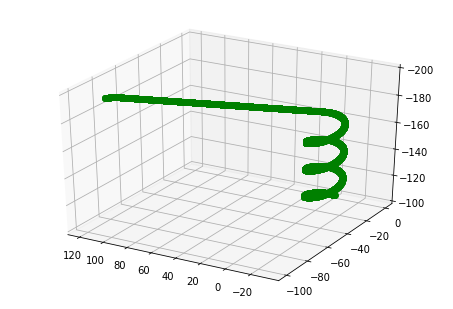

In [28]:
import numpy as np
import time
import sys

pi = np.pi
dubins_case = 12
verbose_flag = 0
plot_flag = 1

class ExecutionFlags(object):
    """
        Execution flags
    """  
    def __init__(self, verbose_flag, plot_flag):
        self.verbose = verbose_flag
        self.plot = plot_flag

class VehicleParameters(object):
    """
        Vehicle Parameters
    """ 
    def __init__(self, Vairspeed_0, Bank_max, Gamma_max):
        self.Vairspeed_0 = Vairspeed_0
        self.Bank_max = Bank_max
        self.Gamma_max = Gamma_max
    
def main():
    # Example main for the 16 cases Dubins Airplane paths
    t0 = time.clock()
    VehiclePars = VehicleParameters( 10, pi/4, pi/12 ) 
    ExFlags = ExecutionFlags( verbose_flag,plot_flag )
    
    flag_nc = 0
    fname = 'path_dubins_solution.txt'
    
    if dubins_case == 1: # short climb RSR
        print('### Path Type: short climb RSR' )
        start_node  = np.array( [0,   0,   -100,   0*pi/180,    VehiclePars.Vairspeed_0] )
        end_node    = np.array( [0, 200,   -125, 270*pi/180,    VehiclePars.Vairspeed_0] )
    elif dubins_case == 2: # short climb RSL
        print('### Path Type: short climb RSL')
        start_node  = np.array([ 0,   0,    -100, -70*pi/180,    VehiclePars.Vairspeed_0] )
        end_node    = np.array( [100, 100,  -125, -70*pi/180,    VehiclePars.Vairspeed_0] )
    elif dubins_case == 3: # short climb LSR
        print('### Path Type: short climb LSR')
        start_node  = np.array( [0,   0,    -100, 70*pi/180,    VehiclePars.Vairspeed_0] )
        end_node    = np.array( [100, -100, -125, 70*pi/180,    VehiclePars.Vairspeed_0] )
    elif dubins_case == 4: # short climb LSL
        print('### Path Type: short climb LSL')
        start_node  = np.array( [0,   0,    -100,  70*pi/180,   VehiclePars.Vairspeed_0] )
        end_node    = np.array( [100, -100, -125, -135*pi/180,  VehiclePars.Vairspeed_0] )
    elif dubins_case == 5: # long climb RSR
        print('### Path Type: long climb RSR')
        start_node  = np.array( [0,   0,   -100,   0*pi/180,    VehiclePars.Vairspeed_0] )
        end_node    = np.array( [0, 200,   -250, 270*pi/180,    VehiclePars.Vairspeed_0] )
    elif dubins_case == 6: # long climb RSL
        print('### Path Type: long climb RSL')
        start_node  = np.array( [0,   0,    -100, -70*pi/180,    VehiclePars.Vairspeed_0] )
        end_node    = np.array( [100, 100,  -350, -70*pi/180,    VehiclePars.Vairspeed_0] )
    elif dubins_case == 7: # long climb LSR
        print('### Path Type: long climb LSR')
        start_node  = np.array( [0,   0,    -350, 70*pi/180,    VehiclePars.Vairspeed_0] )
        end_node    = np.array( [100, -100, -100, 70*pi/180,    VehiclePars.Vairspeed_0] )
    elif dubins_case == 8: # long climb LSL
        print('### Path Type: long climb LSL')
        start_node  = np.array( [0,   0,    -350,  70*pi/180,   VehiclePars.Vairspeed_0] )
        end_node    = np.array( [100, -100, -100, -135*pi/180,  VehiclePars.Vairspeed_0] )
    elif dubins_case == 9: # intermediate climb RLSR (climb at beginning)
        print('### Path Type: intermediate climb RLSR (climb at beginning)')
        start_node  = np.array( [0,   0,   -100,   0*pi/180,     VehiclePars.Vairspeed_0] )
        end_node    = np.array( [0, 200,   -200, 270*pi/180,    VehiclePars.Vairspeed_0] )
    elif dubins_case == 10: # intermediate climb RLSL (climb at beginning)
        print('### Path Type: intermediate climb RLSL (climb at beginning)')
        start_node  = np.array( [0,   0,   -100, 0*pi/180,     VehiclePars.Vairspeed_0] )
        end_node    = np.array( [100, 100, -200, -90*pi/180,   VehiclePars.Vairspeed_0] )
    elif dubins_case == 11: # intermediate climb LRSR (climb at beginning)
        print('### Path Type: intermediate climb LRSR (climb at beginning)')
        start_node  = np.array( [0,   0,   -100, 0*pi/180,     VehiclePars.Vairspeed_0] )
        end_node    = np.array( [100, -100, -200, 90*pi/180,    VehiclePars.Vairspeed_0] )
    elif dubins_case == 12: # intermediate climb LRSL (climb at beginning)
        print('### Path Type: intermediate climb LRSL (climb at beginning)')
        start_node  = np.array( [0,   0,   -100, 0*pi/180,     VehiclePars.Vairspeed_0] )
        end_node    = np.array( [100, -100, -200, -90*pi/180,   VehiclePars.Vairspeed_0] )
    elif dubins_case == 13: # intermediate climb RSLR (descend at end)
        print('### Path Type: intermediate climb RSLR (descend at end)')
        start_node  = np.array( [0,   0,   -200, 0*pi/180,     VehiclePars.Vairspeed_0] )
        end_node    = np.array( [100, 100, -100, 90*pi/180,    VehiclePars.Vairspeed_0] )
    elif dubins_case == 14: # intermediate climb RSRL (descend at end)
        print('### Path Type: intermediate climb RSRL (descend at end)')
        start_node  = np.array( [0,   0,   -200, 0*pi/180,     VehiclePars.Vairspeed_0] )
        end_node    = np.array( [100, 100, -100, -90*pi/180,   VehiclePars.Vairspeed_0] )
    elif dubins_case == 15: # intermediate climb LSLR (descend at end)
        print('### Path Type: intermediate climb LSLR (descend at end)')
        start_node  = np.array( [0,   0,   -200, 70*pi/180,     VehiclePars.Vairspeed_0] )
        end_node    = np.array( [100, -100, -100, 90*pi/180,    VehiclePars.Vairspeed_0] )
    elif dubins_case == 16: # intermediate climb LSRL (descend at end)
        print('### Path Type: intermediate climb LSRL (descend at end)')
        start_node  = np.array( [0,   0,   -150, 0*pi/180,     VehiclePars.Vairspeed_0] )
        end_node    = np.array( [100, -100,-100, -90*pi/180,   VehiclePars.Vairspeed_0] )
    elif dubins_case == 0: # for fixing errors
        print('### Path Type: for fixing errors')
        start_node  = np.array( [0,   0,   0, 0, VehiclePars.Vairspeed_0] )
        end_node    = np.array( [40, -140,  100, 11*pi/9, VehiclePars.Vairspeed_0] ) # LSRL
        #end_node    = np.array( [40, -140,  140, 2*pi/9, VehiclePars.Vairspeed_0] ) # LSLR

        #end_node    = np.array( [40, 140,  140, 11*pi/9, VehiclePars.Vairspeed_0] ) # RSLR
        #end_node    = np.array( [40, 140,  140, 1*pi/9, VehiclePars.Vairspeed_0] ) # RSRL

        #end_node    = np.array( [40, 140,  -140, 11*pi/9, VehiclePars.Vairspeed_0] ) # RLSR
        end_node    = np.array( [60, 140,  -140, 0*pi/14, VehiclePars.Vairspeed_0] ) # RLSL
        #end_node    = np.array( [40, -140,  -100, 11*pi/9, VehiclePars.Vairspeed_0] ) # LRSL        
        end_node    = np.array( [40, -140,  -100, 10*pi/180, VehiclePars.Vairspeed_0] ) # LRSR        
        
    if dubins_case > 16:
        flag_nc = 1
        print('Not a case')
    
    if flag_nc == 0:
        print('### Case loaded.')
        print('### computing path...')
        R_min = MinTurnRadius_DubinsAirplane( VehiclePars.Vairspeed_0, VehiclePars.Bank_max )
        
        # Check if start and end node are too close. Since spiral-spiral-spiral (or curve-curve-curve) paths are not considered, the optimal path may not be found... (see Shkel, Lumelsky, 2001, Classification of the Dubins set, Prop. 5/6). Below is a conservative bound, which seems (by experiments) to assure a unproblematical computation of the dubins path.
        if ( np.linalg.norm(end_node[0:2] - start_node[0:2],ord=2) < 6*R_min ):
            print("!!!!!!!!!!!!!!!!")
            print("Conservative condition (end_node[0:2] - start_node[0:2],ord=2) < 6*R_min) not fulfilled!")
            print("Start and end pose are close together. Path of type RLR, LRL may be optimal")
            print("May fail to compute optimal path! Aborting")
            print("!!!!!!!!!!!!!!!!")
            sys.exit()
        
        
        DubinsAirplaneSolution = DubinsAirplanePath( start_node, end_node, R_min, VehiclePars.Gamma_max )
        if ExFlags.verbose :
            PrintSolutionAgainstMATLAB( DubinsAirplaneSolution )
        
        path_dubins_airplane = ExtractDubinsAirplanePath( DubinsAirplaneSolution )
        path_dubins_airplane = path_dubins_airplane.T
        print('### Execution time = ' + str( time.clock() - t0 ))
        np.savetxt( fname, path_dubins_airplane.T, delimiter = ',' ) 
        print('### Dubins airplane solution saved in ' + fname)
        if ExFlags.plot :
            print('### Dubins airplane solution plot')
            plot3( path_dubins_airplane[:,0], path_dubins_airplane[:,1], path_dubins_airplane[:,2], 'o', 'g' )
        
        # print 'Press any button to continue'
        # raw_input()


def testAllCases():
    #for dubins_case in xrange(1, 16):
    main()
    print('Press any button to continue')
    input()
        

if __name__ == "__main__":
    testAllCases()